<a href="https://colab.research.google.com/github/asadali163/Time-Series-Experiments/blob/main/codebase/GRU_and_LSTM_(for_time_series).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalMaxPooling1D, LSTM, GRU, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# Import mean absolute percentage error
from sklearn.metrics import mean_absolute_percentage_error

np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
!wget -O airline.csv https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-08-01 07:11:33--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline.csv’

airline.csv         100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-08-01 07:11:34 (26.6 MB/s) - ‘airline.csv’ saved [2036/2036]



In [ ]:
df = pd.read_csv('airline.csv', index_col="Month", parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


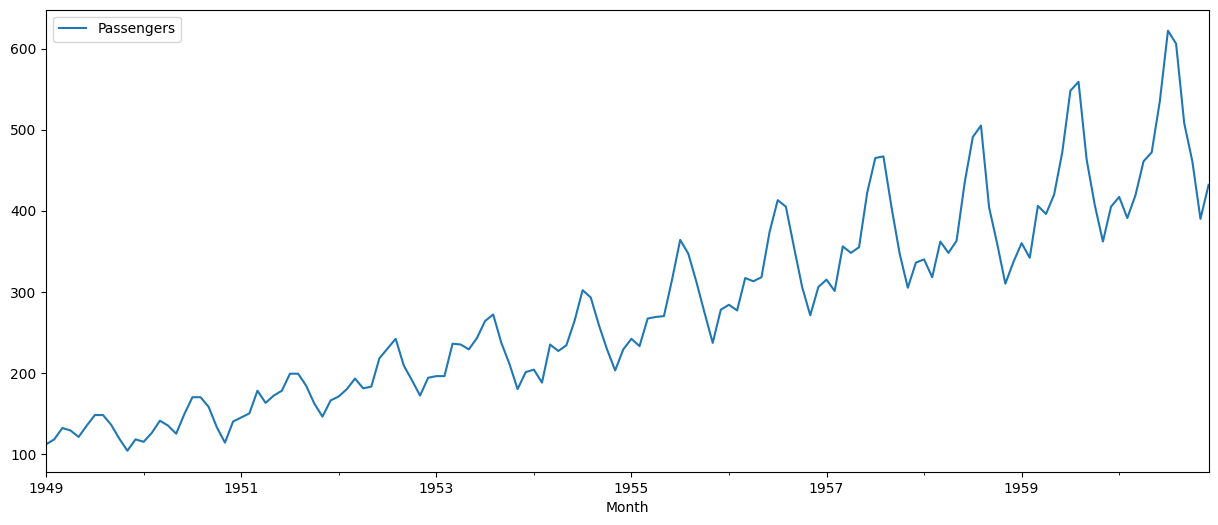

In [ ]:
df.plot(figsize=(15,6));

In [ ]:
df.shape

(144, 1)

In [ ]:
df.isnull().sum()

,0
Passengers,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [ ]:
df['LogPassengers'] = np.log(df['Passengers'])

In [ ]:
N_test = 12
train = df[:-N_test]
test = df[-N_test:]

In [ ]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [ ]:
train.shape, test.shape

((132, 2), (12, 2))

In [ ]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

### Let's prepare the dataset, We will first do 1step forecast

In [ ]:
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X, Y = [], []

for t in range(len(series) - T):
  x = series[t:t+T]
  y = series[t+T]
  X.append(x)
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
print(X.shape, Y.shape)

(133, 10, 1) (133,)


In [ ]:
X_train, X_test = X[:-N_test], X[-N_test:]
Y_train, Y_test = Y[:-N_test], Y[-N_test:]
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(121, 10, 1) (12, 10, 1)
(121,) (12,)


Let's build now simplt LSTM model

In [ ]:
i = Input(shape=(T,1))
x = LSTM(24)(i)
x = Dense(1)(x)

model = Model(i, x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 10, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 24)                  │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,521 (9.85 KB)

 Trainable params: 2,521 (9.85 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
r = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=80, batch_size=32)

Epoch 1/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 2/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 3/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 4/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 5/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 6/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 7/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0102 - val_loss: 0.0097
Epoch 8/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0099 - val_loss: 0.0094
Epoch 9/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 10/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 11/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0091 - val_loss: 0.0082
Epoch 12/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0087 - val_loss: 0.0077


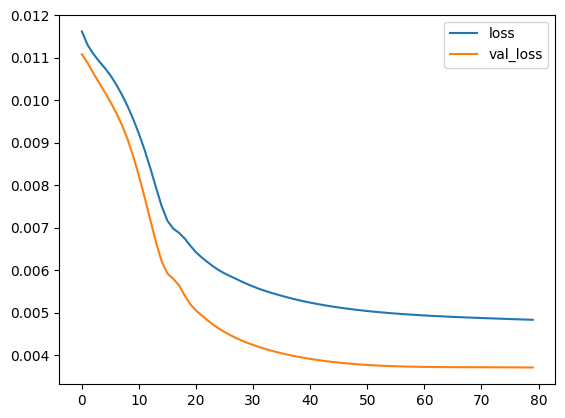

In [ ]:
# Let's plot the loss graph
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

In [ ]:
# Let's have predict the values
X_pred_train = model.predict(X_train).flatten()
X_pred_test = model.predict(X_test).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [ ]:
train_idx[:T+1] = False

In [ ]:
df['ShiftDiffLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftDiffLogPassengers']

In [ ]:
df.loc[train_idx, '1step pred train'] = X_pred + prev[train_idx]
df.loc[test_idx, '1step pred test'] = X_pred_test + prev[test_idx]

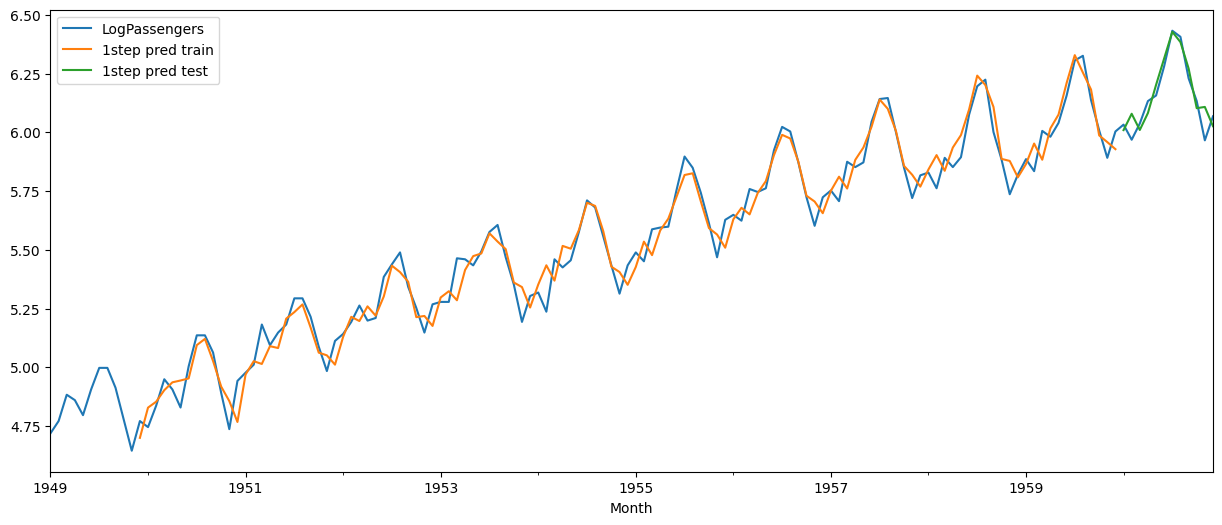

In [ ]:
# Let's plot
df[['LogPassengers', '1step pred train', '1step pred test']].plot(figsize=(15,6));

Let's do now multistep forecast

In [ ]:
last_train = train.iloc[-1]['LogPassengers']

In [ ]:
multistep_predictions = []

last_x = X_test[0]

while len(multistep_predictions) < N_test:
  p = model.predict(last_x.reshape(1, T, 1))[0]
  multistep_predictions.append(p)

  last_x = np.roll(last_x, -1)
  last_x[-1] = p

multistep_predictions = np.array(multistep_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [ ]:
df.loc[test_idx, 'Multistep pred test'] = last_train + np.cumsum(multistep_predictions)

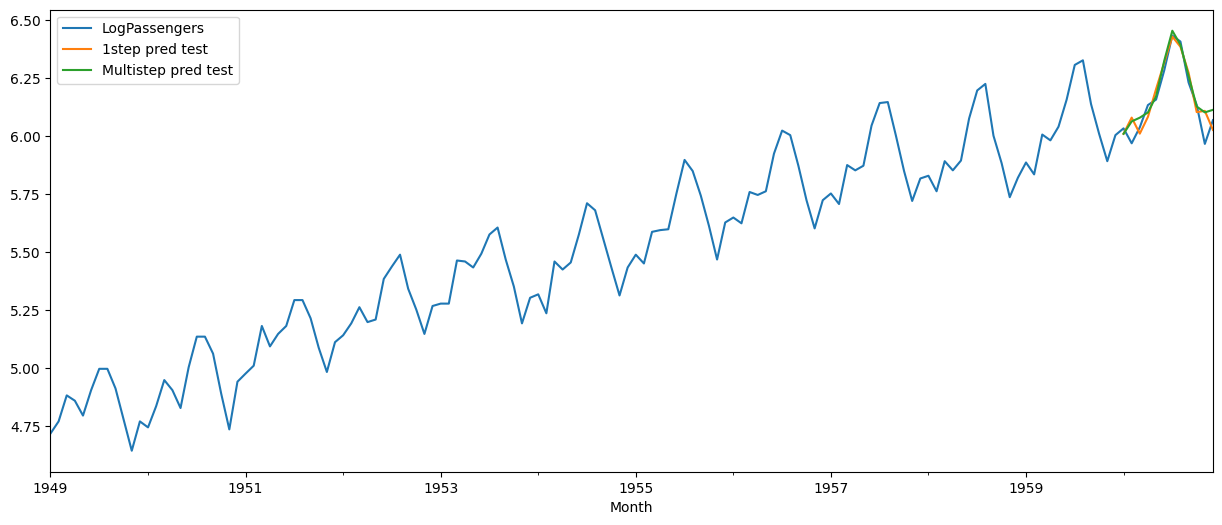

In [ ]:
# Let's plot
df[['LogPassengers', '1step pred test','Multistep pred test']].plot(figsize=(15,6));

So it is not clear from graph that which one is better

#### Let's do now Multi output forecast

In [ ]:
Tx = T
Ty = N_test
X, Y = [], []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  y = series[t+Tx:t+Tx+Ty]
  X.append(x)
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y)
print(X.shape, Y.shape)

(122, 10, 1) (122, 12)


In [ ]:
X_train_m = X[:-1]
X_test_m = X[-1:]
Y_train_m = Y[:-1]
Y_test_m = Y[-1:]
print(X_train_m.shape, X_test_m.shape)
print(Y_train_m.shape, Y_test_m.shape)

(121, 10, 1) (1, 10, 1)
(121, 12) (1, 12)


In [ ]:
# Let's now build the LSTM model for multioutput forecast
i = Input(shape=(Tx,1))
x = LSTM(24, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)

model_m = Model(i, x)
model_m.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 10, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 10, 24)              │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_4               │ (None, 24)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 12)                  │             300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,796 (10.92 KB)

 Trainable params: 2,796 (10.92 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoints = ModelCheckpoint('model_m_best.keras', save_best_only=True, monitor='val_loss')

In [ ]:
model_m.compile(optimizer='adam', loss='mse')

In [ ]:
r = model_m.fit(X_train_m, Y_train_m, validation_data=(X_test_m, Y_test_m), epochs=300, batch_size = 32, callbacks=[checkpoints])

Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0112 - val_loss: 0.0110
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0111 - val_loss: 0.0107
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 9/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 10/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 11/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 12/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0107 - val_l

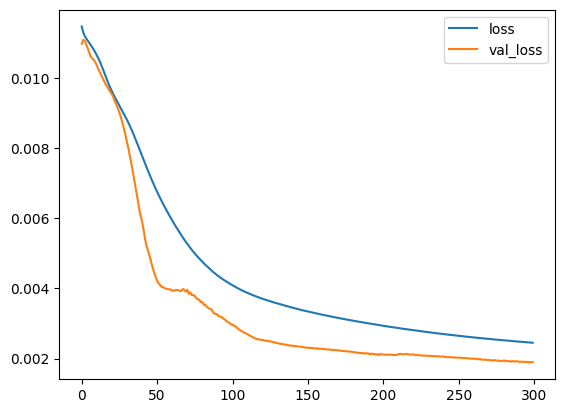

In [ ]:
# Plot loss graph
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

In [ ]:
# Load best model
model_m_best = tf.keras.models.load_model('model_m_best.keras')

In [ ]:
# Let's predict the test values
X_pred_train_m = model_m_best.predict(X_train_m)
X_pred_test_m = model_m_best.predict(X_test_m)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [ ]:
X_pred_train_m.shape, X_pred_test_m.shape

((121, 12), (1, 12))

In [ ]:
# Save _test only
df.loc[test_idx, 'Multioutput pred test'] = last_train + np.cumsum(X_pred_test_m[0])

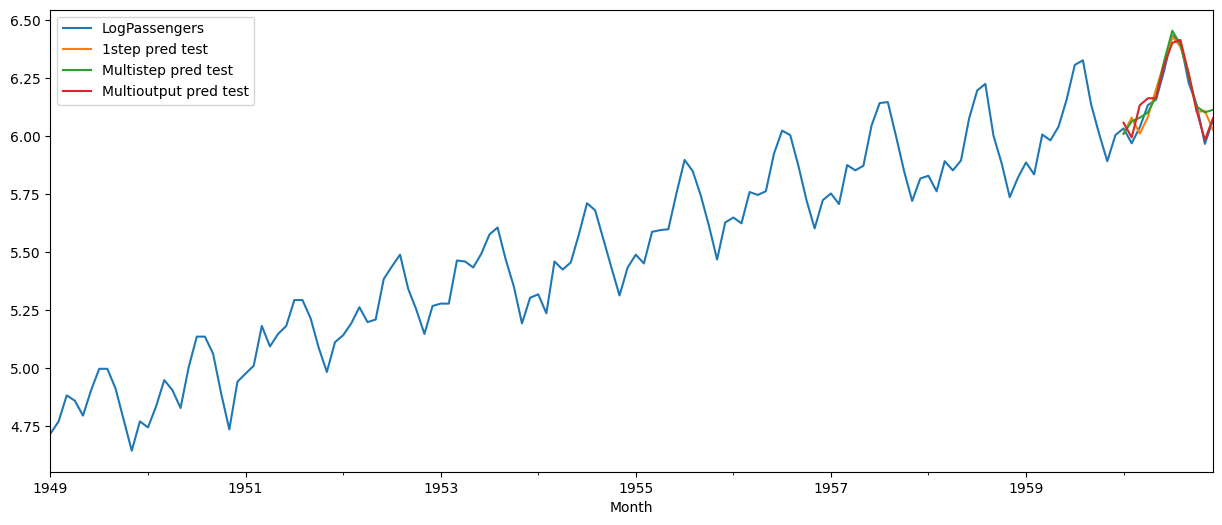

In [ ]:
# Let's plot 1step, multistep and multioutput
df[['LogPassengers', '1step pred test', 'Multistep pred test', 'Multioutput pred test']].plot(figsize=(15,6));

In [ ]:
# Let's confirm with MAPE

mape_multistep = mean_absolute_percentage_error(test['LogPassengers'], df.loc[test_idx, 'Multistep pred test'])
mape_multioutput = mean_absolute_percentage_error(test['LogPassengers'], df.loc[test_idx, 'Multioutput pred test'])

print(f'MAPE for multistep: {mape_multistep}')
print(f'MAPE for multioutput: {mape_multioutput}')

MAPE for multistep: 0.006798130557839656
MAPE for multioutput: 0.004529642466103657


So as we can see that the multioutput forecast is better then the multistep